In [3]:
#!pip install tensorflow

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
import warnings
warnings.filterwarnings('ignore')

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 50

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/dataset-alzheimer/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/dataset-alzheimer/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


2022-12-03 00:00:47.291484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [7]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

2022-12-03 00:00:48.035756: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


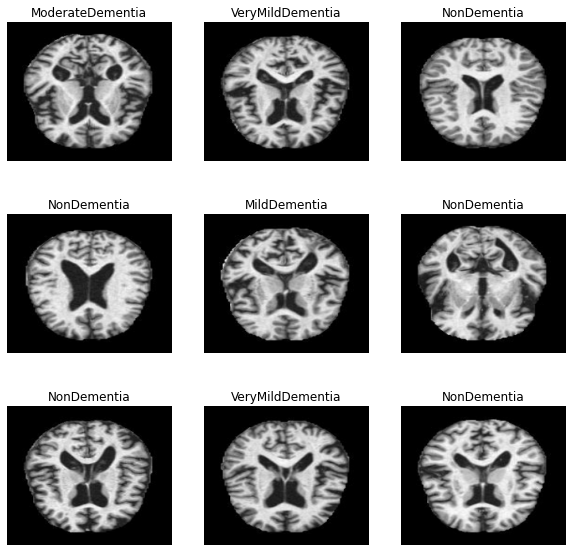

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "../input/dataset-alzheimer/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [12]:
NUM_IMAGES

[717, 52, 2560, 1792]

In [13]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [14]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [15]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [16]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]

    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [17]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/50
257/257 [==============================] - 87s 325ms/step - loss: 1.0887 - accuracy: 0.7656 - precision: 0.5542 - recall: 0.3183 - auc: 0.7839 - val_loss: 8.9871 - val_accuracy: 0.7512 - val_precision: 0.5025 - val_recall: 0.4883 - val_auc: 0.6707
Epoch 2/50
257/257 [==============================] - 76s 294ms/step - loss: 0.9915 - accuracy: 0.7771 - precision: 0.6133 - recall: 0.2934 - auc: 0.8075 - val_loss: 1.6534 - val_accuracy: 0.7476 - val_precision: 0.4951 - val_recall: 0.4951 - val_auc: 0.7452
Epoch 3/50
257/257 [==============================] - 75s 290ms/step - loss: 0.9430 - accuracy: 0.7887 - precision: 0.6725 - recall: 0.3022 - auc: 0.8224 - val_loss: 2.8633 - val_accuracy: 0.7551 - val_precision: 0.5116 - val_recall: 0.4541 - val_auc: 0.7273
Epoch 4/50
257/257 [==============================] - 76s 297ms/step - loss: 0.9389 - accuracy: 0.7933 - precision: 0.7062 - recall: 0.2968 - auc: 0.8255 - val_loss: 1.1862 - val_accuracy: 0.7500 - val_precision: 0.0000e+00

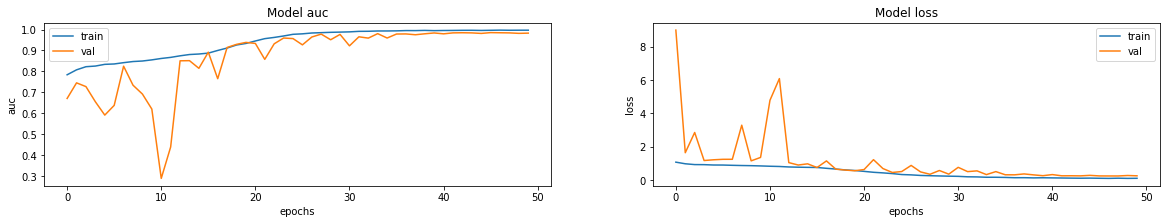

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/dataset-alzheimer/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [21]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 6s 77ms/step - loss: 1.5065 - accuracy: 0.8313 - precision: 0.6633 - recall: 0.6607 - auc: 0.8593
